In [1116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, XGBRegressor
import shap

In [1117]:
df = pd.read_csv("data_bucket/finance_final.csv")
df.head()

,ticker,quarter,quarter_end,Q_End_Price,prev_quarter,prev_quarter_end,Prev_Q_End_Price,CoQ #,CoQ %,Up/Down
0,NVR,Q4-24,31/12/2024,8178.899902,Q3-24,30/09/2024,9811.799805,-1632.899903,-17%,Down
1,NVR,Q2-24,30/06/2024,7588.560059,Q1-24,31/03/2024,8099.959961,-511.399902,-6%,Down
2,NVR,Q3-24,30/09/2024,9811.799805,Q2-24,30/06/2024,7588.560059,2223.239746,29%,Up
3,NVR,Q1-24,31/03/2024,8099.959961,Q4-23,31/12/2023,7000.450195,1099.509766,16%,Up
4,NVR,Q3-23,30/09/2023,5963.299805,Q2-23,30/06/2023,6350.620117,-387.320312,-6%,Down


In [1118]:
df["Up/Down"].value_counts()

Up/Down
Up      6540
Down    4330
Name: count, dtype: int64

In [1119]:
df['CoQ % Numeric'] = df['CoQ %'].str.replace('%', '', regex=False).astype(float)

In [1120]:
df.shape

(10870, 11)

In [1121]:
filtered_df = df[abs(df['CoQ % Numeric']) > 20]

In [1122]:
#filtered_df.sort_values(by = ["CoQ % Numeric"], ascending = False).head(n=30)

In [1123]:
df = df[["ticker", "quarter", "Up/Down"]]

In [1124]:
df.head()

,ticker,quarter,Up/Down
0,NVR,Q4-24,Down
1,NVR,Q2-24,Down
2,NVR,Q3-24,Up
3,NVR,Q1-24,Up
4,NVR,Q3-23,Down


In [1125]:
sectors = pd.read_csv("data_bucket/ticker_sector_industry.csv")
sectors.head()

,ticker,sector,industry
0,A,Healthcare,Diagnostics & Research
1,AAL,Industrials,Airlines
2,AAP,Consumer Cyclical,Auto Parts
3,AAPL,Technology,Consumer Electronics
4,ABBV,Healthcare,Drug Manufacturers - General


In [1126]:
df = df.merge(sectors, how = "left", on = "ticker")

In [1127]:
df['q_num'] = df['quarter'].str.extract(r'Q([1-4])').astype(str)

In [1128]:
sentiment = pd.read_csv("big_fat_test.csv")
sentiment.head()

,Unnamed: 0,ticker,quarter_year,neutral_dominance,net_sentiment,sentiment_entropy,overall_sentiment
0,0,ABT,Q4-19,True,0.151515,1.200079,neutral
1,1,ABT,Q4-20,True,-0.250000,1.067690,neutral
2,2,ABT,Q4-21,True,0.250000,0.811278,neutral
3,3,ABT,Q4-22,True,-0.133540,1.260520,neutral
4,4,AMD,Q4-19,True,0.041096,1.210129,neutral


In [1129]:
sentiment = sentiment[["ticker", "quarter_year", "neutral_dominance", "net_sentiment", "sentiment_entropy", "overall_sentiment"]]
sentiment = sentiment.rename(columns = {"quarter_year" : "quarter"})

In [1130]:
sentiment = sentiment.drop_duplicates()

In [1131]:
sentiment["quarter"].value_counts()

quarter
Q3-23    490
Q4-21    483
Q4-22    480
Q3-22    468
Q3-24    465
Q1-24    464
Q3-21    463
Q2-24    462
Q3-19    460
Q2-23    459
Q1-19    455
Q2-21    455
Q1-20    454
Q3-20    453
Q2-22    453
Q2-19    453
Q2-20    453
Q4-20    452
Q4-19    451
Q1-21    444
Q1-22    436
Q1-23    421
Q4-24     45
Name: count, dtype: int64

In [1132]:
sentiment = sentiment.sort_values(by = "quarter", ascending = True)
sentiment[sentiment["quarter"] == "Q4-19"]

,ticker,quarter,neutral_dominance,net_sentiment,sentiment_entropy,overall_sentiment
9377,ULTA,Q4-19,True,0.250000,0.811278,neutral
1976,XYL,Q4-19,False,-0.076389,1.396717,neutral
1793,UAA,Q4-19,False,0.010309,1.532180,neutral
1524,DVN,Q4-19,True,0.000000,-0.000000,neutral
1527,UPS,Q4-19,True,0.008811,1.304781,neutral
...,...,...,...,...,...,...
8298,TPR,Q4-19,False,-0.314685,1.442002,negative
5029,CAH,Q4-19,True,0.000000,-0.000000,neutral
8738,TDG,Q4-19,True,0.034483,1.162867,neutral
5012,RJF,Q4-19,True,-0.031818,1.104296,neutral


In [1133]:
df = df.merge(sentiment, how = "left", on = ["quarter", "ticker"])
df.head()

,ticker,quarter,Up/Down,sector,industry,q_num,neutral_dominance,net_sentiment,sentiment_entropy,overall_sentiment
0,NVR,Q4-24,Down,Consumer Cyclical,Residential Construction,4,NaN,NaN,NaN,NaN
1,NVR,Q2-24,Down,Consumer Cyclical,Residential Construction,2,False,-0.032967,1.379340,neutral
2,NVR,Q3-24,Up,Consumer Cyclical,Residential Construction,3,False,0.000000,1.402993,neutral
3,NVR,Q1-24,Up,Consumer Cyclical,Residential Construction,1,True,-0.012500,1.208177,neutral
4,NVR,Q3-23,Down,Consumer Cyclical,Residential Construction,3,False,-0.139785,1.366244,neutral


In [1134]:
df = df.dropna(axis="index", subset=['net_sentiment'])

In [1135]:
df.shape

(9471, 10)

In [1136]:
df["quarter"].value_counts()

quarter
Q3-23    483
Q4-22    467
Q3-24    461
Q1-24    460
Q2-24    458
Q4-21    452
Q2-23    450
Q3-22    449
Q2-22    431
Q3-21    429
Q2-21    420
Q4-20    414
Q3-20    412
Q1-22    410
Q2-20    410
Q1-20    408
Q1-21    406
Q3-19    406
Q4-19    405
Q1-23    403
Q2-19    396
Q1-19    396
Q4-24     45
Name: count, dtype: int64

In [1137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9471 entries, 1 to 10966
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ticker             9471 non-null   object 
 1   quarter            9471 non-null   object 
 2   Up/Down            9471 non-null   object 
 3   sector             9471 non-null   object 
 4   industry           9471 non-null   object 
 5   q_num              9471 non-null   object 
 6   neutral_dominance  9471 non-null   object 
 7   net_sentiment      9471 non-null   float64
 8   sentiment_entropy  9471 non-null   float64
 9   overall_sentiment  9471 non-null   object 
dtypes: float64(2), object(8)
memory usage: 813.9+ KB


In [1138]:
df["industry"].unique()

array(['Residential Construction', 'Travel Services', 'Auto Parts',
       'Diagnostics & Research', 'Software - Application',
       'Aerospace & Defense', 'Biotechnology',
       'Drug Manufacturers - General', 'Industrial Distribution',
       'Discount Stores', 'Semiconductor Equipment & Materials',
       'Semiconductors', 'REIT - Specialty', 'Medical Devices',
       'Telecom Services', 'Rental & Leasing Services', 'Entertainment',
       'Information Technology Services',
       'Medical Instruments & Supplies', 'Software - Infrastructure',
       'Financial Data & Stock Exchanges', 'Medical Distribution',
       'Specialty Retail', 'Capital Markets', 'Restaurants',
       'Healthcare Plans', 'Communication Equipment', 'Apparel Retail',
       'Internet Content & Information', 'Specialty Industrial Machinery',
       'Credit Services', 'Scientific & Technical Instruments',
       'Specialty Chemicals', 'Asset Management', 'Building Materials',
       'Insurance - Diversified', '

In [819]:
#df = df.sort_values(by = "quarter", ascending = True).reset_index(drop=True)

<function matplotlib.pyplot.show(close=None, block=None)>

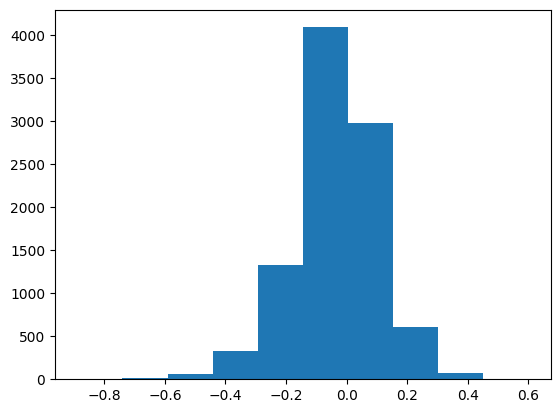

In [1139]:
plt.hist(df["net_sentiment"])
plt.show

In [821]:
#df.sort_values(by = "net_sentiment", ascending = True)

In [885]:
#df[df["ticker"] == "NVDA"]

In [786]:
#df_test1 = df[df["industry"] == "Lodging"]

In [785]:
#df_test1.sort_values(by = "net_sentiment", ascending = True)

In [772]:
df_test = df[df["sector"] == "Communication Services"]

In [773]:
df_test.sort_values(by = "net_sentiment", ascending = True)

,ticker,quarter,Up/Down,sector,industry,q_num,neutral_dominance,net_sentiment,sentiment_entropy,overall_sentiment
5274,LYV,Q4-21,Up,Communication Services,Entertainment,4,False,-0.583333,0.979869,negative
7617,LYV,Q4-20,Up,Communication Services,Entertainment,4,False,-0.538462,0.995727,negative
9614,CMCSA,Q2-20,Up,Communication Services,Telecom Services,2,False,-0.389610,1.261202,neutral
10742,NWSA,Q4-19,Up,Communication Services,Entertainment,4,False,-0.320000,1.358969,neutral
10709,NWS,Q4-19,Up,Communication Services,Entertainment,4,False,-0.320000,1.358969,neutral
...,...,...,...,...,...,...,...,...,...,...
4152,LYV,Q2-22,Down,Communication Services,Entertainment,2,True,0.214953,1.251193,neutral
3363,EA,Q3-21,Down,Communication Services,Electronic Gaming & Multimedia,3,True,0.229008,1.009641,neutral
6516,LYV,Q2-23,Up,Communication Services,Entertainment,2,True,0.242718,1.253246,neutral
5277,LYV,Q3-23,Down,Communication Services,Entertainment,3,False,0.263158,1.305729,neutral


In [188]:
#df["quarter"].value_counts()

In [1174]:
#feature_cols = ['net_sentiment','sector', 'q_num',"neutral_dominance","sentiment_entropy","overall_sentiment"]
feature_cols = ['net_sentiment','industry', 'q_num','neutral_dominance']
X = df[feature_cols]
y = df['Up/Down'].map({'Down': 0, 'Up': 1})

In [1175]:
from sklearn.model_selection import train_test_split

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [1176]:
X_train.shape, X_test.shape, X_val.shape, y_val.shape, y_train.shape, y_test.shape

((6842, 4), (1421, 4), (1208, 4), (1208,), (6842,), (1421,))

In [1177]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9471 entries, 1 to 10966
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   net_sentiment      9471 non-null   float64
 1   industry           9471 non-null   object 
 2   q_num              9471 non-null   object 
 3   neutral_dominance  9471 non-null   object 
dtypes: float64(1), object(3)
memory usage: 370.0+ KB


In [1178]:
num_selector = make_column_selector(dtype_include=['float64'])
cat_selector = make_column_selector(dtype_include=['object'])

In [1179]:
num_pipeline = make_pipeline(
    MinMaxScaler()
)
cat_pipeline = make_pipeline(
    OneHotEncoder(sparse_output = False, drop='if_binary')
)

In [1180]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_selector),
        ('cat', cat_pipeline, cat_selector)
    ]
)

In [1181]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1f04866b00>),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1f04866830>)])

In [1200]:
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_estimators=100,
        learning_rate = 0.05
    ))
])

In [1201]:
X_test.dtypes

net_sentiment        float64
industry              object
q_num                 object
neutral_dominance     object
dtype: object

In [1202]:
import time

# Start timer
start_time = time.time()
pipeline.fit(X_train, y_train)
end_time = time.time()

In [1203]:
end_time - start_time

11.451520681381226

In [1204]:
preprocessor.set_output(transform='pandas')

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1f04866b00>),
                                ('cat',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f1f04866830>)])

In [1205]:
preprocessor.fit_transform(X_train)

,num__net_sentiment,cat__industry_Advertising Agencies,cat__industry_Aerospace & Defense,cat__industry_Agricultural Inputs,cat__industry_Airlines,cat__industry_Apparel Manufacturing,cat__industry_Apparel Retail,cat__industry_Asset Management,cat__industry_Auto & Truck Dealerships,cat__industry_Auto Manufacturers,...,cat__industry_Utilities - Regulated Electric,cat__industry_Utilities - Regulated Gas,cat__industry_Utilities - Regulated Water,cat__industry_Utilities - Renewable,cat__industry_Waste Management,cat__q_num_1,cat__q_num_2,cat__q_num_3,cat__q_num_4,cat__neutral_dominance_True
3809,0.597015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2242,0.508308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1212,0.632364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6758,0.528943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2613,0.668977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,0.522388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5945,0.666978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
10438,0.636994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
8809,0.552239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [1206]:
y_test_pred = pipeline.predict(X_test)

In [1207]:
from sklearn.metrics import accuracy_score

In [1208]:
accuracy_score(y_test, y_test_pred)

0.6213933849401829

In [1209]:
y.value_counts(normalize=True)

Up/Down
1    0.60775
0    0.39225
Name: proportion, dtype: float64

In [1210]:
xgb_model = pipeline.named_steps['classifier']
X_test_transformed = pipeline.named_steps['preprocessing'].transform(X_test)

In [1211]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_transformed)

In [1212]:
# Extract column names
num_features = pipeline.named_steps['preprocessing'].named_transformers_['num'].get_feature_names_out()
cat_features = pipeline.named_steps['preprocessing'].named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out()

# Combine feature names
feature_names = np.concatenate([num_features, cat_features])

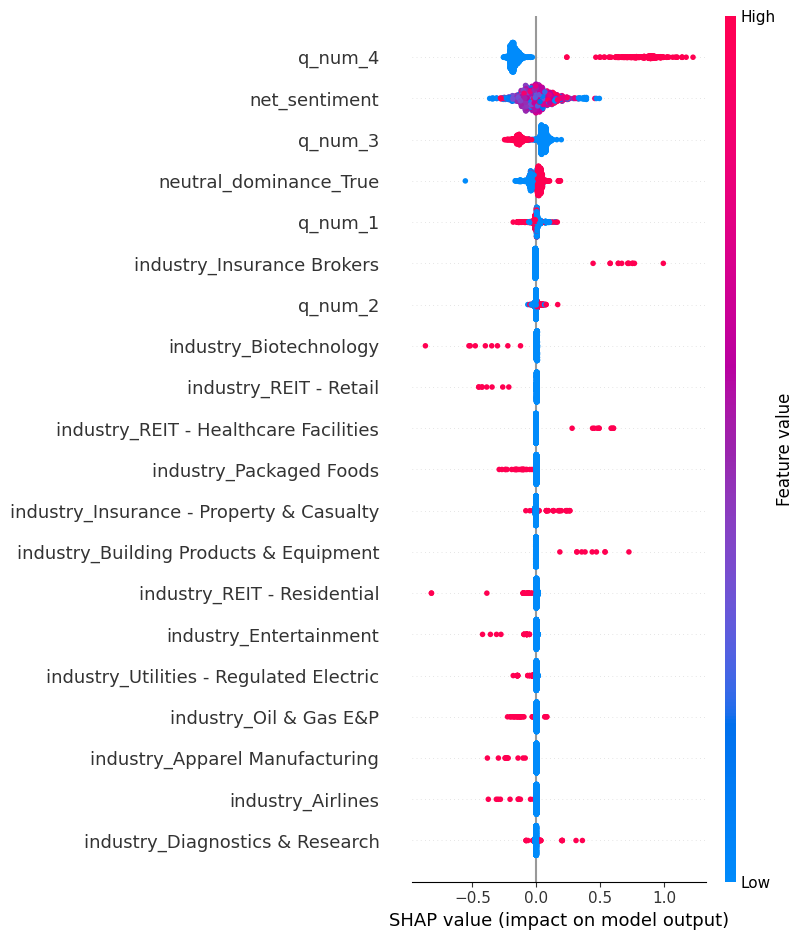

In [1213]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

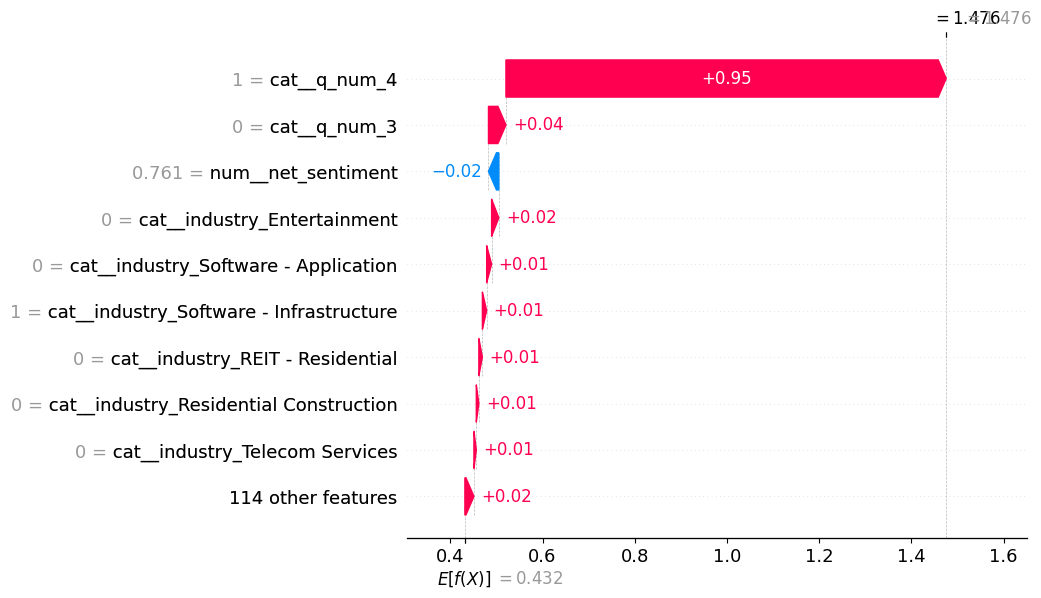

In [884]:
shap.plots.waterfall(shap_values[0])

In [42]:
#binary model
def initialize_model():
    model = Sequential()
    model.add(Input(shape=(2,)))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(20, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = initialize_model()

history = model.fit(X_train,
                    y_train,
                    epochs=1,
                    batch_size=16,
                    verbose=0)

NameError: name 'Sequential' is not defined

In [ ]:
model = XGBClassifier(random_state=1, use_label_encoder=True, n_estimators=128)